# S2S RNN to predict next state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis
from Process_Training_Data_2 import group_by_path
from Process_Training_Data_2 import get_mean_error
from Process_Training_Data_2 import add_end_state

importing Jupyter notebook from Process_Training_Data_2.ipynb


### Get the data
First Import it using pandas

In [5]:
file = "OSPA_landing_data.csv"

In [6]:
STEPS=25

dataset = Process_Training_Data_2.get_data("./data/"+file)

dataset_distances= dataset[["id_camino","D0",'D1',"D2","D3",'D4',"D5","A0","A1"]]

#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)
exteneded_dataset= add_end_state(dataset_distances)

action_vector = ["A0","A1"]
normed_dataset, data_stats = Process_Training_Data_2.normalize_data(exteneded_dataset, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,STEPS,position)

#dataset2 = group_by_path(normed_dataset)

In [7]:
Zero_Target= [0,0,0,0,0,0]
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

D0    0.0
D1    0.0
D2    0.0
D3    0.0
D4    0.0
D5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [8]:
def multivariate_data(dataset, target, start_index, end_index):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i,indices,:])

    labels.append(target[i, 1:])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [9]:
np.random.shuffle(dataset2)

In [10]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None)

In [11]:
BATCH_SIZE = 1
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

sample_weight

In [69]:

sample_weight= tf.constant([[[1,1,1,1,1,1],[2,2,2,2,2,2],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3]]])
sample_weight

<tf.Tensor: shape=(1, 8, 6), dtype=int32, numpy=
array([[[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3]]])>

In [71]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear'))

loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_fn, metrics=['mse','mae'])

### Inspect the model

In [73]:
single_step_sequential_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 11)          792       
_________________________________________________________________
dense_2 (Dense)              (None, None, 6)           72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [75]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 100

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 160.0 steps, validate for 50 steps
Epoch 1/100
160/160 [==============================] - 3s 19ms/step - loss: 0.1039 - mse: 0.1039 - mae: 0.1615 - val_loss: 0.1424 - val_mse: 0.1424 - val_mae: 0.1839
Epoch 2/100
160/160 [==============================] - 3s 18ms/step - loss: 0.1038 - mse: 0.1038 - mae: 0.1615 - val_loss: 0.1423 - val_mse: 0.1423 - val_mae: 0.1839
Epoch 3/100
160/160 [==============================] - 3s 16ms/step - loss: 0.1036 - mse: 0.1036 - mae: 0.1614 - val_loss: 0.1423 - val_mse: 0.1423 - val_mae: 0.1839
Epoch 4/100
160/160 [==============================] - 3s 19ms/step - loss: 0.1035 - mse: 0.1035 - mae: 0.1613 - val_loss: 0.1422 - val_mse: 0.1422 - val_mae: 0.1838
Epoch 5/100
160/160 [==============================] - 3s 19ms/step - loss: 0.1033 - mse: 0.1033 - mae: 0.1612 - val_loss: 0.1422 - val_mse: 0.1422 - val_mae: 0.1838
Epoch 6/100
160/160 [==============================] - 2s 14ms/step - loss: 0.1032 - mse: 0.1032 - mae: 0.1612 - val_loss: 0.

In [77]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [79]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

41/41 - 0s - loss: 0.1507 - mse: 0.1507 - mae: 0.1882


Visualize the model's training progress.

In [80]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

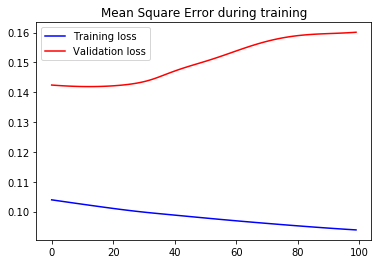

In [81]:
plot_train_history(single_step_sequential_history,
                   'Mean Square Error during training')

#### Adding early stop

In [82]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0938,  mae:0.1544,  mse:0.0938,  val_loss:0.1602,  val_mae:0.1962,  val_mse:0.1602,  
...........

In [83]:
single_step_sequential_model.save("./data/S2S_S2S_model_2_"+file+".h5") 

## Decoder Mode

In [34]:
def generate_trajectory_Decoder(model, start, target, initial_action, data_stats):

    model.reset_states()

    # initialize cost
    cost = 0

    # Empty vector to store the actions
    actions = []

    #initialize action vector
    actions.append(initial_action)

    # First point is the initial distance

    # Compute the initial distance
    distance_long = target - start
    
    # normalize to get the Neuronal Network input
    distance = norm(distance_long[0:6], data_stats)
    trajectory_generated = tf.expand_dims([distance], 0)


    for i in range(100):

        dummy_trajectory=model.predict(trajectory_generated)
        last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

        if  (last_step[0,0,0] <= 0.02):
            last_step[0,0,0] = 0
            trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
            end_message = "End"
            break

        trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
        end_message = "Error"
    
    print(end_message)

    New_trajectory = np.squeeze(trajectory_generated)

    trajectory_generated_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    return trajectory_generated_denorm, cost, actions, end_message


## Get validation statistics

In [13]:
model = tf.keras.models.load_model("./data/S2S_S2S_model_2_"+file+".h5")

0.6773645710855609


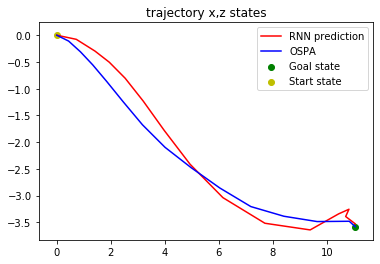

In [14]:
t_number = 4
S_Trajectory_prediction=x_val_single_sequential[t_number,0,:]
S_Trajectory_prediction = np.reshape(S_Trajectory_prediction, (1,1,6))

for i in range(20):

    dummy_trajectory=model.predict(S_Trajectory_prediction)
    last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

    if  (last_step[0,0,0] <= 0.01):
        last_step[0,0,0] = 0
        S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)
        break
    S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)

New_trajectory = np.squeeze(S_Trajectory_prediction)

Trajectory_prediction_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)

min_len = min(len(y_val_denorm),len(Trajectory_prediction_denorm[1:]))

mse =sklearn.metrics.mean_squared_error(y_val_denorm[:min_len,0:2], Trajectory_prediction_denorm[1:min_len+1,0:2])

print(mse)


start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
target = x_val_denorm[0] + start

pred_trajectory_states = target - Trajectory_prediction_denorm
OSPA_trajectory_states =  target - y_val_denorm
OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

plt.figure()

plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='r', label='RNN prediction')
plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='b', label='OSPA')
plt.scatter(target[0],target[1], c='g', label='Goal state')
plt.scatter(start[0], start[1], c='y', label='Start state')
plt.title("trajectory x,z states")
plt.legend()

plt.show()


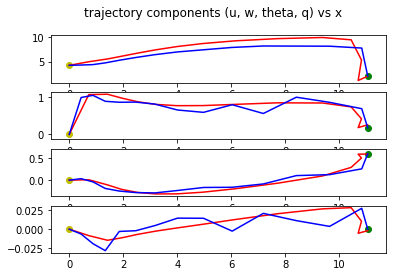

In [59]:
fig, axs = plt.subplots(4)

for i in range(4):

    component= i+2

    axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='r', label='RNN Prediction')
    axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='b', label='OSPA')
    axs[i].scatter(target[0],target[component], c='g', label='Goal state')
    axs[i].scatter(start[0], start[component], c='y', label='Start start')

fig.suptitle("trajectory components (u, w, theta, q) vs x")

fig.show()

In [16]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [17]:
def get_trajectory_results(x_single_sequential, y_single_sequential, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(y_single_sequential)):

        x_denorm = np.apply_along_axis(denorm,1,x_single_sequential[t_number],data_stats)

        y_denorm = np.apply_along_axis(denorm,1,y_single_sequential[t_number],data_stats)

        initial_action = [0,0]
        start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
        target = x_denorm[0] + start

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  target - y_denorm
        OSPA_trajectory_states=np.insert(OSPA_trajectory_states,0,start, axis=0)

        min_len = min(len(y_denorm),len(trajectory[1:]))

        mse =sklearn.metrics.mean_squared_error(y_denorm[:min_len,0:2], trajectory[1:min_len+1,0:2])


        results.at[t_number, "time"] = time.time() - start_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])

    return results


In [25]:
def get_trajectory_results_2(trajectoty_list, data_stats):
    results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "mean_distance","end_message"])

    for t_number in range(len(trajectoty_list)):

        initial_action = [0,0]
        start = trajectoty_list[t_number][0,-2]
        target = trajectoty_list[t_number][0,-1]

        start_time = time.time()

        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

        pred_trajectory_states = target - trajectory
        OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]

        min_len = min(len(OSPA_trajectory_states),len(trajectory))

        mse =sklearn.metrics.mean_squared_error(OSPA_trajectory_states[0:min_len,0:2], pred_trajectory_states[0:min_len,0:2])


        results.at[t_number, "time"] = time.time() - start_time
        results.at[t_number, "actions"] = np.array(actions)
        results.at[t_number, "path"] = np.array(trajectory)
        results.at[t_number, "sqrt(trajectory MSE)"] = math.sqrt(mse)
        results.at[t_number, "cost"] = cost
        results.at[t_number, 'distance_to_target'] = distance_error(*trajectory[-1,0:2])
        results.at[t_number, 'end_message'] = end_message
        results.at[t_number, "mean_distance_in_trajectory"] = get_mean_error(OSPA_trajectory_states, pred_trajectory_states, num=10, eps = 5)
        results.at[t_number, "k_value"] = abs(target[1])/abs(target[0])

    return results

In [19]:
def results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["all","result_end", "result_error"])
    
    for metric in metrics:
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

In [20]:
results = get_trajectory_results(x_val_single_sequential, y_val_single_sequential, data_stats)

Error
Error
Error
End
End
End


IndexError: index 21 is out of bounds for axis 0 with size 21

In [28]:
metrics = ["time",'distance_to_target', "mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value"]
results_summary(results, metrics)

NameError: name 'results' is not defined

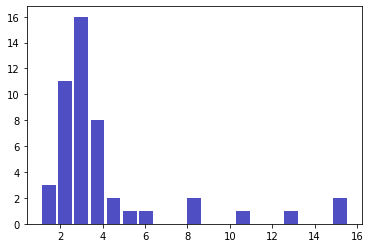

In [133]:

n, bins, patches = plt.hist(x=val_results["sqrt(trajectory MSE)"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

## Compare with heuristic results

In [40]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [42]:
def get_heuristic_results(samples):
    results= samples.copy()
    for sample_id, row in results.iterrows():
        print(sample_id)
        initial_action = np.array(results['h_actions'][sample_id][0])
        start = np.array(results['initial_state'][sample_id])
        target = np.array(results['final_state'][sample_id])
        start_time = time.time()
        trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
        results.at[sample_id, "h_time"] = time.time() - start_time
        results.at[sample_id, "h_actions"] = np.array(actions)
        results.at[sample_id, "h_path"] = np.array(trajectory)
        results.at[sample_id, "h_cost"] = cost
        results.at[sample_id, 'h_distance'] = distance_error(*trajectory[-1,0:2])
        results.at[sample_id, 'end_message'] = end_message
    return results

In [43]:
def heuristic_results_summary(results, metrics):
    results_summary = pd.DataFrame(columns = ["sample", "result_end", "result_error", "all results"])
    
    for metric in metrics:
        comparsion_table.at[metric, "sample"] = samples[metric].mean()
        results_summary.at[metric, "result_end"] = results[metric].loc[results['end_message'] == "End"].mean()
        results_summary.at[metric, "result_error"] = results[metric].loc[results['end_message'] == "Error"].mean()
        results_summary.at[metric, "all"] = results[metric].mean()

    print(results["time"].loc[results['end_message'] == "Error"].count()/len(results))
    return results_summary

In [ ]:
#results = get_heuristic_results(samples)
#metrics = ["h_time","h_distance","h_cost"]
#heuristic_results_summary(results, metrics)

In [41]:
col = ['D0','D1','D2','D3','D4','D5']
distances = []
for sample_id, row in samples.iterrows():
    target = np.array(results['final_state'][sample_id])
    for sample in  samples['h_path'][sample_id]:
        distances.append(target[0:6]-sample[0:6])
distances = np.array(distances)
df = pd.DataFrame (distances, columns = col)
data_stats_T = df.describe()
data_stats_T = data_stats_T.transpose()

KeyError: 'final_state'

## Datos globales

In [46]:
#TRAIN_SPLIT = len(dataset2)
#features_dataset = dataset2[:,:,:6]
#target_dataset = dataset2[:,0:,:6]

#x_full_single_sequential, y_full_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT)


In [21]:
# = get_trajectory_results(x_full_single_sequential, y_full_single_sequential, data_stats)

In [22]:
dataset_trajectories = dataset[["id_camino","C0",'C1',"C2","C3",'C4',"C5","A0","A1","initial_state", "goal_state"]]

In [40]:
trajectory_list = group_by_path(dataset_trajectories)

In [37]:
full_results= get_trajectory_results_2(trajectory_list, data_stats)

or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
Error
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
End
End
End
End
End
End
End
Error
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
index 101 is out of bounds for axis 0 with size 101
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
index 

In [38]:
metrics = ["time",'distance_to_target', "mean_distance_in_trajectory","sqrt(trajectory MSE)", "k_value"]
results_summary(full_results, metrics)

0.04477611940298507


,all,result_end,result_error
time,1.30886,0.940846,9.15976
distance_to_target,1.77992,0.64363,26.0208
mean_distance_in_trajectory,1.56749,1.62578,0.323944
sqrt(trajectory MSE),2.51242,2.40453,4.81416
k_value,0.470104,0.485322,0.145465


In [39]:
full_results['distance_to_target'].loc[full_results['k_value'] > 0.25].mean()

0.6893518849534709

In [60]:
def plot_trajectory_2(trajectory_list, data_stats, t_number):

    initial_action = [0,0]
    start = trajectoty_list[t_number][0,-2]
    target = trajectoty_list[t_number][0,-1]

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    pred_trajectory_states = target - trajectory
    OSPA_trajectory_states =  trajectoty_list[t_number][:,0:6]


    plt.figure()

    plt.plot(pred_trajectory_states[:,0], pred_trajectory_states[:,1], c='r', label='RNN prediction')
    plt.plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,1], c='b', label='OSPA')
    plt.scatter(target[0],target[1], c='g', label='Goal state')
    plt.scatter(start[0], start[1], c='y', label='Start state')
    plt.title("trajectory x,z states")
    plt.legend()

    plt.show()

    fig, axs = plt.subplots(4)

    for i in range(4):

        component= i+2

        axs[i].plot(pred_trajectory_states[:,0],pred_trajectory_states[:,component], c='r', label='RNN Prediction')
        axs[i].plot(OSPA_trajectory_states[:,0], OSPA_trajectory_states[:,component],  c='b', label='OSPA')
        axs[i].scatter(target[0],target[component], c='g', label='Goal state')
        axs[i].scatter(start[0], start[component], c='y', label='Start start')

    fig.suptitle("trajectory components (u, w, theta, q) vs x")

    fig.show()

End


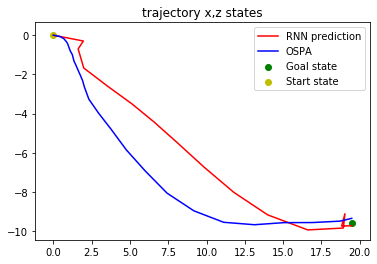

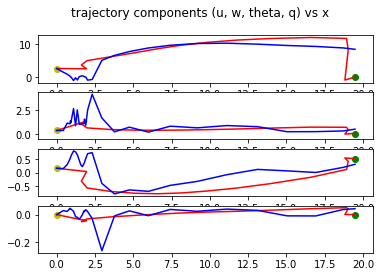

In [63]:
t_number = 33
plot_trajectory_2(trajectory_list, data_stats, t_number)